In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > query_date).\
    order_by(Measurement.date).all()
#print(precip)

# Query All Records in the the Database
precip_data = pd.read_sql("SELECT * FROM Measurement", conn)
#precip_data
#type(precip_data)


Query Date:  2016-08-23


In [11]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip, columns=['date', 'prcp']).set_index("date")
precip_df

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


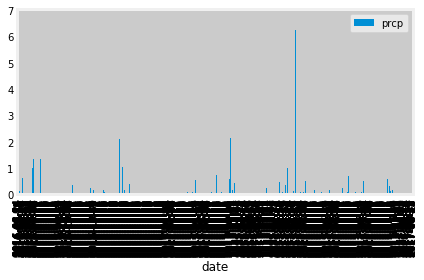

In [12]:
# Sort the dataframe by date
precip_df.groupby("date")
#precip_data
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot.bar()
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# calling describe method 
desc = precip_df.describe() 
  
# display 
desc 

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [30]:
# Design a query to show how many stations are available in this dataset?
#stn_nam = session.query(Measurement.station.distinct()).all()
#stn_nam

stn_num = session.query(func.count(Measurement.station.distinct())).one()
print(stn_num)

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)? 

# List the stations and the counts in descending order.

active_stn = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).all()

active_stn

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
#session.query(Measurement.tobs, func.min(Measurement.tobs).filter(Measurement.station == 'USC00519281')).one()
session.query(Measurement.tobs, func.max(Measurement.tobs).filter(Measurement.station == 'USC00519281')).all()
#session.query(Measurement.tobs, func.avg(Measurement.tobs).filter(Measurement.station == 'USC00519281')).one()

[(85.0, 85.0)]

Text(0.5, 1.0, 'Hawaii Temperature')

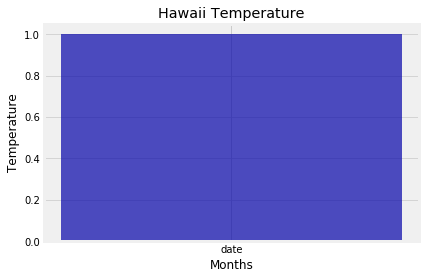

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temps = session.query(Measurement.tobs).\
    filter(Measurement.date > '2016-08-23').\
    group_by(Measurement.tobs).order_by(Measurement.date).all()

plt.hist(x='date', bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.title('Hawaii Temperature')


![precipitation](Images/station-histogram.png)

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [46]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
 
# Calculate the trip dates 
prev_year_start = dt.date(2018, 3, 15) - dt.timedelta(days=365)
prev_year_end = dt.date(2018, 3, 25) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

65.0 72.6 78.0


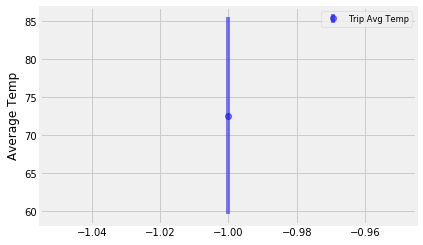

In [71]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Give chart a title
#plt.title("Trip Avg Temp")

# Plot sample means with error bars
fig, ax = plt.subplots()

ax.errorbar(x=0-1, y=tavg, yerr=tmax-tmin, fmt="o", color="b",
            alpha=0.5, label="Trip Avg Temp")

#ax.set_xlim(-0.5, len(means))

ax.set_ylabel("Average Temp")


plt.legend(loc="best", fontsize="small", fancybox=True)
plt.tight_layout
plt.show()

In [70]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# Calculate the trip dates
sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date <= (prev_year_start).\
    filter(Measurement.date <= prev_year_end).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()

SyntaxError: unexpected EOF while parsing (<ipython-input-70-b780144feabf>, line 10)

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
